# VGG16 모델을 이용하여 이미지 분류하기

## 개와 고양이 이미지 분류하기

* 문제 1-1. VGG16 모델 구현하기
    * 영상의 내용을 참고하여 직접 코드로 모델을 구현해 보세요. Batch Normalization, Parameter Initialization 등을 사용할 수도 있습니다.
* 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기
    * skip connection, pre-trained model 등 다양한 방법을 사용하여 기본적인 VGG16 모델의 성능보다 높은 정확도를 구해보세요.

**라이브러리 불러오기**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


**캐글에서 제공되는 개와 고양이 데이터를 불러오기**
* test 데이터에서 1은 개, 0은 고양이를 의미

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True) # _URL로부터 'cats_and_dogs.zip' 파일을 다운로드하고 압축을 해제

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [4]:
# train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [5]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [6]:
# train 데이터와 validation 데이터 개수를 알아보자.
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat image:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog image:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat image: 1000
total training dog image: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


**필요한 파라미터를 설정(파라미터를 수정하면 성능을 높일 수 있다)**

In [7]:
# parameter Initialization
batch_size = 8
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [8]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

**train 데이터가 총 2000장으로 데이터 양이 많지 않으니, Data Augmentation을 통해 데이터 수를 늘린다.**

* Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것이다. 
* range의 숫자를 변화시키거나 Flip에서 True/False를 적절하게 사용하여 다양한 실험을 해보자.

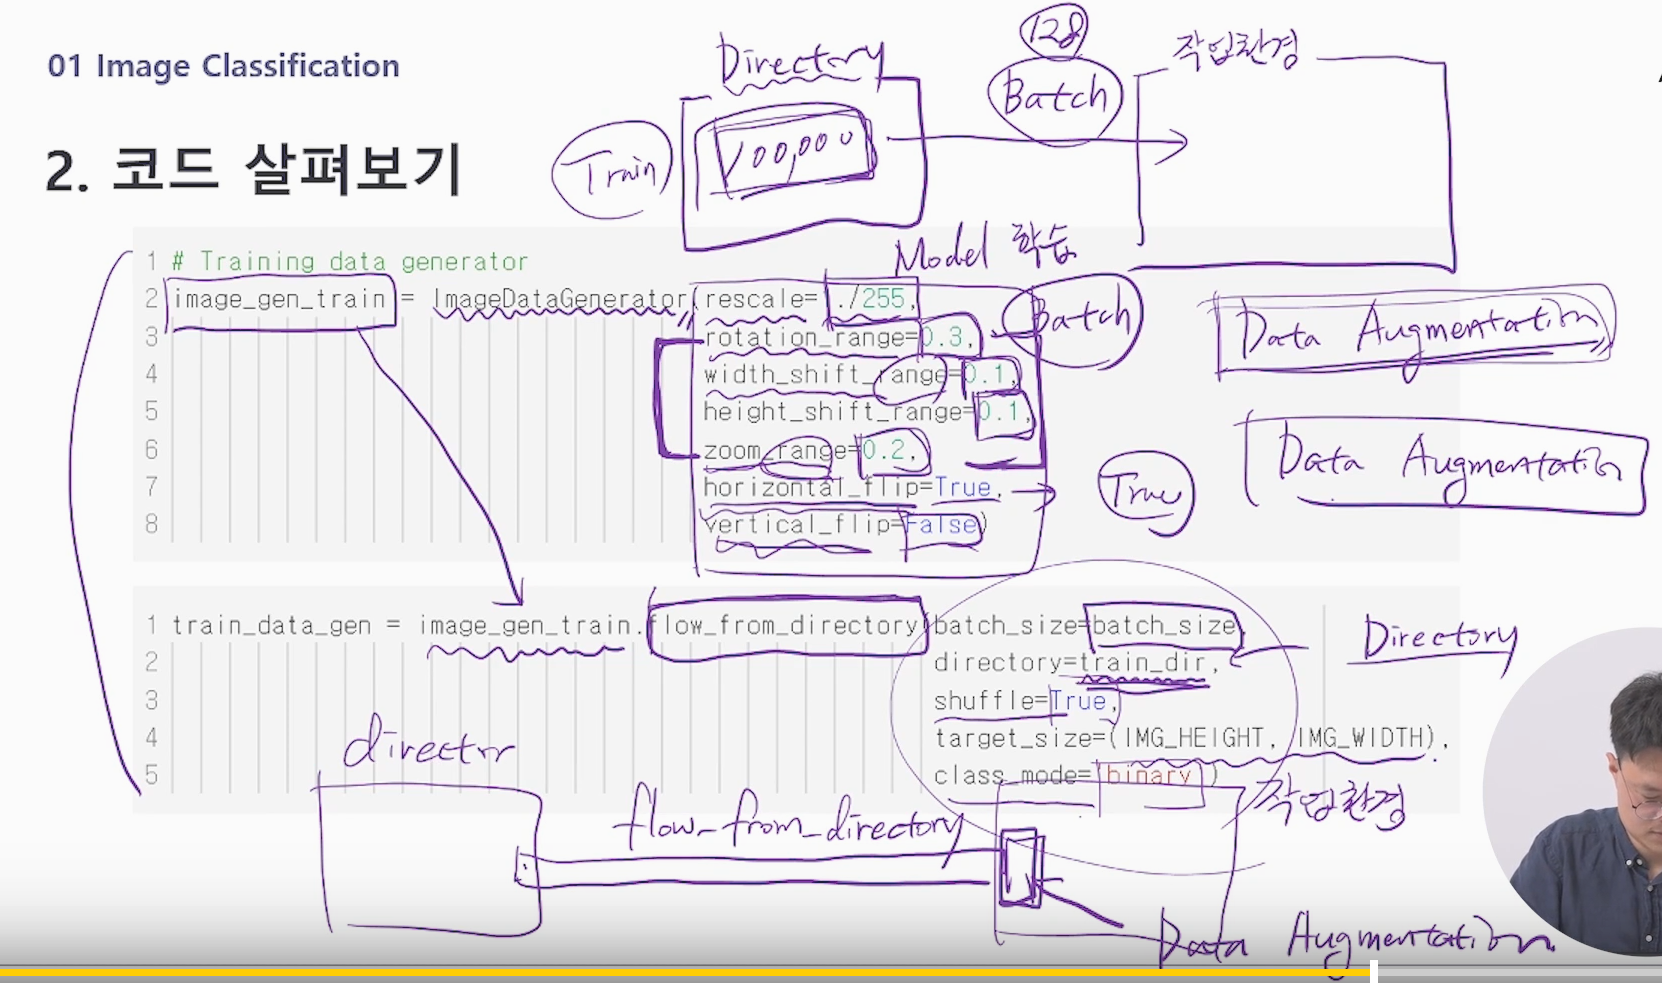

- directory로부터 데이터를 batch 단위씩만 가져와서 데이터 증강을 적용해서 데이터를 불리고, 그리고 모델을 학습시키는 데 쓴다.
- 또 directory로부터 데이터를 batch 단위씩 가져와서 데이터 증강을 적용해 데이터를 불리고, 그리고 그 데이터로 모델을 학습시키고를 반복한다.
- flow_from_directoty를 가지고 일종의 파이프를 만듦
- rotation_range - 사진을 약간 돌림
- width_shift_range - 가로로 약간 이동한다
- height_shift_range - 위, 아래로 약간 이동한다
- zom_range - 좀 확대한다
- horizontal_flip - 가로로 뒤집는다
- vertical_flip - 세로로 뒤집는다
    - rotation_range, width_shift_range, height_shift_range, zom_range 이 네 가지 값은 늘 설정된 값 그대로 적용되지는 않는다.(range라고 표현된 것들의 속 뜻)
- "shuffle = true"는 일반적으로 컴퓨터 프로그래밍이나 소프트웨어에서 사용되는 용어입니다. 이것은 데이터나 요소들을 무작위로 섞는 기능을 나타냅니다. 대부분의 경우, 이것은 리스트(list), 배열(array), 또는 임의의 데이터 집합을 섞는 데 사용됩니다. 예를 들어, 음악 재생 목록을 무작위로 섞거나 카드 게임에서 카드를 섞을 때 사용될 수 있습니다. "shuffle = true"를 설정하면 해당 데이터나 목록이 무작위로 재배열되어 다양한 순서로 표시됩니다.


In [9]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

.flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 준다. 우리는 개와 고양이를 분류하는 task를 수행하기 때문에 class_mode는 'binary'이다. Classification task에 따라 class_mode를 변경하면 된다.

In [10]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                    directory=train_dir,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [11]:
# Data Augmentaion이 제대로 되었는지 확인해 보자.
train_data_gen[0][0].shape

(8, 256, 256, 3)

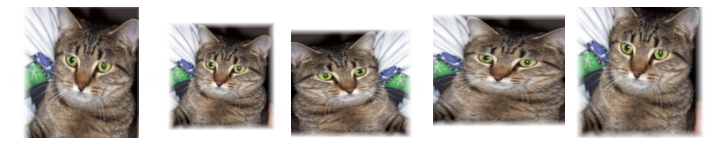

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)] # 데이터 증강된 첫 번째 이미지를 5번 가져와서 리스트에 저장
plotImages(augmented_images)

Validation 데이터에도 train 데이터와 같은 동일한 작업을 해 준다. 그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 준다.

In [13]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [14]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                directory=validation_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')

Found 1000 images belonging to 2 classes.


Validation 데이터를 확인해 보자. 크게 이미지와 정답 데이터로 구성이 되어 있다.

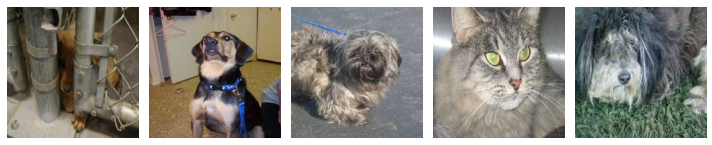

In [15]:
sample_training_images,_ = next(val_data_gen) # 이미지 데이터와 레이블을 각각 변수에 할당
plotImages(sample_training_images[:5])

In [16]:
_[:5] # 정답 데이터

array([1., 1., 1., 0., 1.], dtype=float32)

### 문제 1-1. VGG16 모델 구현하기

In [17]:
# 참고 코드
# input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
# x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
# x=tf.keras.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
# x=tf.keras.layers.BatchNormalization()(x)
# x=tf.keras.layers.MaxPool2D((2, 2))(x)

# x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x=tf.keras.layers.BatchNormalization()(x)
# x=tf.keras.layers.MaxPool2D((2, 2))(x)

# x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
# x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
# x=tf.keras.layers.BatchNormalization()(x)
# x=tf.keras.layers.MaxPool2D((2, 2))(x)

# x=tf.keras.layers.Flatten()(x)
# x=tf.keras.layers.Dense(1024, activation='relu')(x)
# x=tf.keras.layers.Dense(512, activation='relu')(x)
# out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

# model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
# model.summary()

### VGG16 모델의 구조
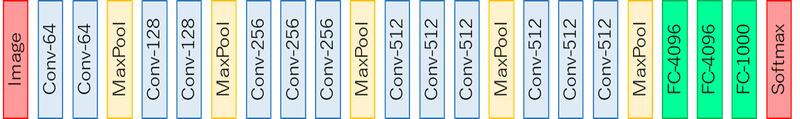

In [18]:
# VGG16 모델의 구조
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584

**손실함수, optimizer, metric을 설정해 준다.**

손실함수와 metric은 분류 task에 따라 다양하게 바꿀 수 있다. optimizer도 Adam 외에 다양한 것을 사용할 수 있으니 자유롭게 바꿔보자.

In [19]:
loss_function = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
metric = tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=[metric])

callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1), 
                tf.keras.callbacks.ModelCheckpoint('image_dog_cat_model.h5', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)]

**모델 학습을 시켜보자**

* data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환한다.
* batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야 한다.
* 만약 batch_size=20이고 steps_per_epoch=100일 경우 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료된다. 단, 크기 20의 batch 데이터는 매번 랜덤으로 생성된다.

**일반적으로 (전체 데이터 길이/batch_size)를 steps_per_epoch으로 설정한다.**

In [22]:
history = model.fit(train_data_gen,
                    steps_per_epoch=(len(os.listdir(train_cats_dir)) +  len(os.listdir(train_dogs_dir)))/batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
#                     callbacks=callbacks_list,
                    validation_freq=1) # 몇 번의 epoch마다 검증 데이터셋(validation data)에서 성능을 검증할지를 나타낸다.
                                        # 이 값은 정수로 지정되며, validation_freq=1은 매 epoch마다 검증 데이터셋에서 성능을 평가하라는 의미이다.
                                        # 만약 validation_freq=2로 설정하면 2번의 epoch마다 한 번씩만 검증 데이터셋에서 성능을 평가하게 된다.

Epoch 1/5
250/250 [==============================] - 56s 221ms/step - loss: 0.6953 - binary_accuracy: 0.4905 - val_loss: 0.6934 - val_binary_accuracy: 0.5000
Epoch 2/5
250/250 [==============================] - 55s 219ms/step - loss: 0.6936 - binary_accuracy: 0.4920 - val_loss: 0.6936 - val_binary_accuracy: 0.4990
Epoch 3/5
250/250 [==============================] - 55s 220ms/step - loss: 0.6939 - binary_accuracy: 0.4930 - val_loss: 0.6934 - val_binary_accuracy: 0.4990
Epoch 4/5
250/250 [==============================] - 55s 220ms/step - loss: 0.6938 - binary_accuracy: 0.4870 - val_loss: 0.6935 - val_binary_accuracy: 0.5000
Epoch 5/5
250/250 [==============================] - 55s 220ms/step - loss: 0.6942 - binary_accuracy: 0.4960 - val_loss: 0.6936 - val_binary_accuracy: 0.5010


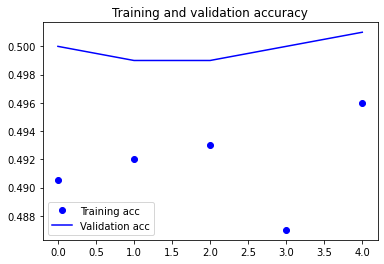

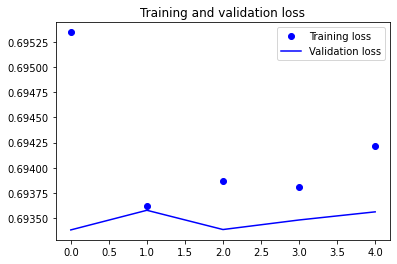

In [23]:
# 시각화를 통해 정확도 알아보기
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기
hyperparameter 변경, 모델 수정, optimizer 변경, skip connection, pre-trained model 등 다양한 방법을 사용하면 모델의 성능을 높일 수 있습니다. 다양한 실험을 통해 성능을 올려 보자.

In [50]:
# parameter Initialization
batch_size = 8
epochs = 10
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [51]:
# 데이터 generator 생성
# Training data generator
image_gen_train1 = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     shear_range=0.2, # 이미지를 전환 변환을 통해 찌그러뜨릴 수 있는 최대 각도를 나타낸다
                                     horizontal_flip=True,
                                     fill_mode='nearest', # 이미지 변형 시 생기는 빈 공간을 어떻게 채울지 결정한다(nearst는 가장 가까운 픽셀 값으로 채우는 것을 의미)
                                     brightness_range=[0.5, 1.5], # 이미지 밝기를 무작위로 조정하는 범위를 지정
                                     vertical_flip=False)

In [52]:
train_data_gen1 = image_gen_train1.flow_from_directory(batch_size=batch_size,
                                                    directory=train_dir,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [53]:
# Data Augmentaion이 제대로 되었는지 확인해 보자.
train_data_gen1[0][0].shape

(8, 256, 256, 3)

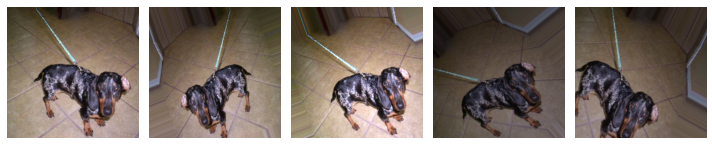

In [54]:
augmented_images = [train_data_gen1[0][0][0] for i in range(5)] # 데이터 증강된 첫 번째 이미지를 5번 가져와서 리스트에 저장
plotImages(augmented_images)

In [55]:
# Validation data generator
image_gen_val1 = ImageDataGenerator(rescale=1./255)

In [56]:
val_data_gen1 = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                directory=validation_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')

Found 1000 images belonging to 2 classes.


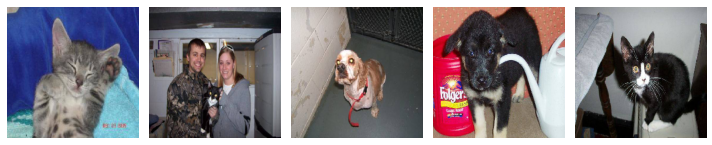

In [57]:
sample_training_images,_ = next(val_data_gen1) # 이미지 데이터와 레이블을 각각 변수에 할당
plotImages(sample_training_images[:5])

In [58]:
_[:5] # 정답 데이터

array([0., 0., 1., 1., 0.], dtype=float32)

In [59]:
# VGG16 모델의 구조
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(input_layer) # he 초기화 설정
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
x= tf.keras.layers.Dropout(0.5)(x) # 드롭아웃 추가
x=tf.keras.layers.Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_25 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 128, 128, 128)     1475

In [60]:
loss_function = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # 학습률을 0.001로 줄였다.
metric = tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=[metric])

callbacks_list= [tf.keras.callbacks.ModelCheckpoint('image_dog_cat_model1.h5', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]

In [61]:
# 모델 학습
history = model.fit(train_data_gen1,
                    steps_per_epoch=(len(os.listdir(train_cats_dir)) +  len(os.listdir(train_dogs_dir)))/batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen1,
                    callbacks=callbacks_list,
                    validation_freq=1) # 몇 번의 epoch마다 검증 데이터셋(validation data)에서 성능을 검증할지를 나타낸다.
                                        # 이 값은 정수로 지정되며, validation_freq=1은 매 epoch마다 검증 데이터셋에서 성능을 평가하라는 의미이다.
                                        # 만약 validation_freq=2로 설정하면 2번의 epoch마다 한 번씩만 검증 데이터셋에서 성능을 평가하게 된다.

Epoch 1/10
250/250 [==============================] - 60s 233ms/step - loss: 8.1794 - binary_accuracy: 0.4990 - val_loss: 1.5571 - val_binary_accuracy: 0.5050
Epoch 2/10
250/250 [==============================] - 58s 231ms/step - loss: 0.8571 - binary_accuracy: 0.5405 - val_loss: 0.8064 - val_binary_accuracy: 0.5480
Epoch 3/10
250/250 [==============================] - 58s 232ms/step - loss: 0.8396 - binary_accuracy: 0.5055 - val_loss: 0.7457 - val_binary_accuracy: 0.5030
Epoch 4/10
250/250 [==============================] - 58s 231ms/step - loss: 0.8076 - binary_accuracy: 0.5255 - val_loss: 0.7616 - val_binary_accuracy: 0.5410
Epoch 5/10
250/250 [==============================] - 58s 230ms/step - loss: 0.8694 - binary_accuracy: 0.5075 - val_loss: 0.7988 - val_binary_accuracy: 0.4660
Epoch 6/10
250/250 [==============================] - 58s 230ms/step - loss: 0.8005 - binary_accuracy: 0.5240 - val_loss: 0.6834 - val_binary_accuracy: 0.5530
Epoch 7/10
250/250 [==========================

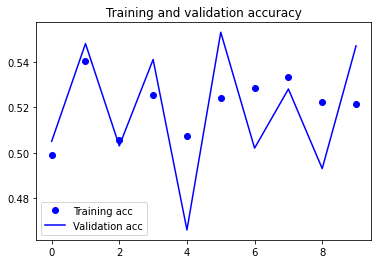

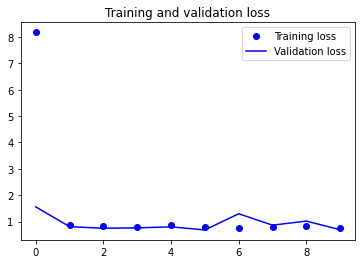

In [62]:
# 시각화를 통해 정확도 알아보기
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

val_binary_accuracy를 봤을 때 처음 그래프를 봤을 때보다, 54퍼센트로 점수는 높아졌지만, 그래프가 많이 튀는 걸 보아, 모델의 성능이 좋지 않고 불안정한 것 같다. 과한 데이터 generator 설정이 독이 됐을까? 초기 generator 설정으로 돌리고, 수정한 모델을 그대로 이어가 본다.

In [63]:
# VGG16 모델의 구조
input_layer=tf.keras.layers.Input(shape=(256, 256, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(input_layer) # he 초기화 설정
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same', kernel_initializer='he_normal')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
x= tf.keras.layers.Dropout(0.5)(x) # 드롭아웃 추가
x=tf.keras.layers.Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_30 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 128, 128, 128)     1475

In [64]:
loss_function = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # 학습률을 0.001로 줄였다.
metric = tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=[metric])

callbacks_list= [tf.keras.callbacks.ModelCheckpoint('image_dog_cat_model1.h5', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]

In [65]:
# 모델 학습
history = model.fit(train_data_gen, # 처음 시도했던 데이터 generator
                    steps_per_epoch=(len(os.listdir(train_cats_dir)) +  len(os.listdir(train_dogs_dir)))/batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen, # 처음 시도했던 데이터 generator
                    callbacks=callbacks_list,
                    validation_freq=1) # 몇 번의 epoch마다 검증 데이터셋(validation data)에서 성능을 검증할지를 나타낸다.
                                        # 이 값은 정수로 지정되며, validation_freq=1은 매 epoch마다 검증 데이터셋에서 성능을 평가하라는 의미이다.
                                        # 만약 validation_freq=2로 설정하면 2번의 epoch마다 한 번씩만 검증 데이터셋에서 성능을 평가하게 된다.

Epoch 1/10
250/250 [==============================] - 60s 233ms/step - loss: 6.9650 - binary_accuracy: 0.5135 - val_loss: 1.3271 - val_binary_accuracy: 0.4580
Epoch 2/10
250/250 [==============================] - 58s 231ms/step - loss: 1.0268 - binary_accuracy: 0.4940 - val_loss: 0.7950 - val_binary_accuracy: 0.5360
Epoch 3/10
250/250 [==============================] - 58s 231ms/step - loss: 0.9354 - binary_accuracy: 0.5145 - val_loss: 0.8000 - val_binary_accuracy: 0.5280
Epoch 4/10
250/250 [==============================] - 58s 230ms/step - loss: 0.8836 - binary_accuracy: 0.5055 - val_loss: 0.7101 - val_binary_accuracy: 0.4560
Epoch 5/10
250/250 [==============================] - 58s 232ms/step - loss: 0.7951 - binary_accuracy: 0.5195 - val_loss: 0.8422 - val_binary_accuracy: 0.4640
Epoch 6/10
250/250 [==============================] - 58s 230ms/step - loss: 0.8120 - binary_accuracy: 0.5195 - val_loss: 0.8488 - val_binary_accuracy: 0.4920
Epoch 7/10
250/250 [==========================

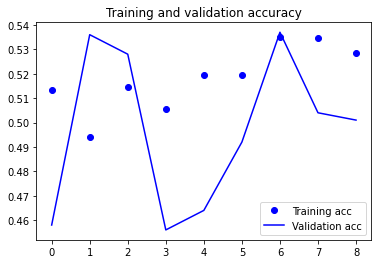

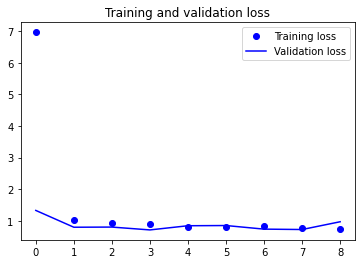

In [66]:
# 시각화를 통해 정확도 알아보기
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

오히려 성능이 더 떨어진 것 같다. 정확도 또한 전 모델에 비해서 떨어졌다. 다른 선택지로 **pre-trained model**을 사용해보자

### Pre-trained model (VGG16)

* weights : 가중치 모델 지정 ( None : 초기화된 가중치, 'imagenet' : 사전 학습된 가중치 )
* include_top : 신경망 FC 층 존재 유무 ( False : 제거 / True : 유지 )
* input_tensor : 입력 텐서 크기 ( Input(shape = (w, h, ch))

In [70]:
# Pre-trained VGG16 Model 불러오기
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.layers import Dense, Dropout, Input
from tensorflow.python.keras.models import Model


input_tensor = Input(shape=(150,150,3))
model = VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor) # Find-Tuning으로 새로운 분류기를 학습하기 위해 기존의 FC (Fully-Connected Layer)를 제거하고 
                                                                                    # 입력되는 이미지의 크기 input_tensor를 지정

58892288/58889256 [==============================] - 0s 0us/step


### VGG 신경망 모델 디자인

In [72]:
# 모델 Layer 데이터화
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Layer 추가
x = layer_dict['block5_pool'].output

# Cov2D Layer
x = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu')(x)

# MaxPooling2D Layer
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten Layer 
x = Flatten()(x)

# FC Layer 
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# new model 정의
new_model = Model(inputs = model.input, outputs = x)

**새롭게 디자인된 VGG16 모델**

In [85]:
# CNN Pre-trained 가중치를 그대로 사용할때
for layer in new_model.layers[:19] :
    layer.trainable = False

new_model.summary()

# 컴파일 옵션
loss_function = 'binary_crossentropy'
optimizer = 'adam'
metric = 'binary_accuracy'
new_model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=[metric])

callbacks_list= [tf.keras.callbacks.ModelCheckpoint('image_dog_cat_model.h5', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [86]:
# parameter Initialization
batch_size = 16
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [87]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

In [88]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                    directory=train_dir,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [89]:
# Data Augmentaion이 제대로 되었는지 확인해 보자.
train_data_gen[0][0].shape

(16, 150, 150, 3)

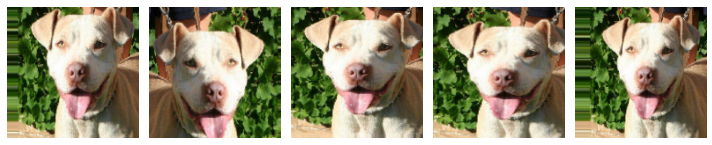

In [90]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)] # 데이터 증강된 첫 번째 이미지를 5번 가져와서 리스트에 저장
plotImages(augmented_images)

In [91]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [92]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                directory=validation_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')

Found 1000 images belonging to 2 classes.


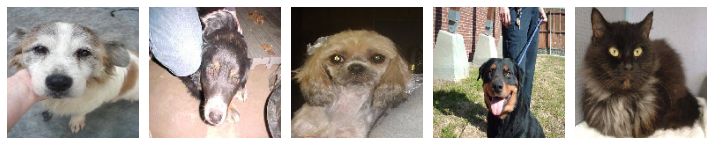

In [93]:
# Validation data 확인
sample_training_images,_ = next(val_data_gen) # 이미지 데이터와 레이블을 각각 변수에 할당
plotImages(sample_training_images[:5])

In [94]:
_[:5] # 정답 데이터

array([1., 1., 1., 1., 0.], dtype=float32)

In [95]:
# 모델 학습
history_new = new_model.fit(train_data_gen, # 처음 시도했던 데이터 generator
                    steps_per_epoch=(len(os.listdir(train_cats_dir)) +  len(os.listdir(train_dogs_dir)))/batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen, # 처음 시도했던 데이터 generator
                    callbacks=callbacks_list,
                    validation_freq=1) # 몇 번의 epoch마다 검증 데이터셋(validation data)에서 성능을 검증할지를 나타낸다.
                                        # 이 값은 정수로 지정되며, validation_freq=1은 매 epoch마다 검증 데이터셋에서 성능을 평가하라는 의미이다.
                                        # 만약 validation_freq=2로 설정하면 2번의 epoch마다 한 번씩만 검증 데이터셋에서 성능을 평가하게 된다.

Epoch 1/20
125/125 [==============================] - 22s 149ms/step - loss: 0.4187 - binary_accuracy: 0.7980 - val_loss: 0.3112 - val_binary_accuracy: 0.8610
Epoch 2/20
125/125 [==============================] - 17s 135ms/step - loss: 0.3244 - binary_accuracy: 0.8580 - val_loss: 0.2803 - val_binary_accuracy: 0.8730
Epoch 3/20
125/125 [==============================] - 17s 135ms/step - loss: 0.2836 - binary_accuracy: 0.8685 - val_loss: 0.2765 - val_binary_accuracy: 0.8720
Epoch 4/20
125/125 [==============================] - 17s 135ms/step - loss: 0.2840 - binary_accuracy: 0.8795 - val_loss: 0.2912 - val_binary_accuracy: 0.8640
Epoch 5/20
125/125 [==============================] - 17s 136ms/step - loss: 0.2437 - binary_accuracy: 0.8940 - val_loss: 0.2919 - val_binary_accuracy: 0.8880
Epoch 6/20
125/125 [==============================] - 17s 135ms/step - loss: 0.2235 - binary_accuracy: 0.9095 - val_loss: 0.2601 - val_binary_accuracy: 0.8790
Epoch 7/20
125/125 [==========================

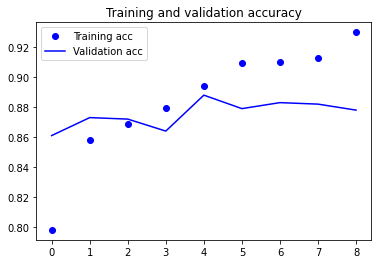

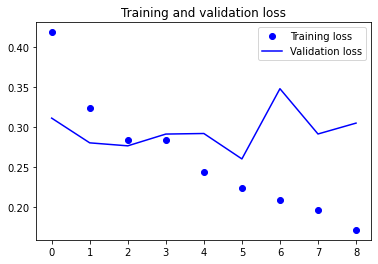

In [96]:
# 시각화를 통해 정확도 알아보기
acc = history_new.history['binary_accuracy']
val_acc = history_new.history['val_binary_accuracy']
loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

확실히 사전 학습 된 VGG16을 쓰기 전보단 성능이 좋아졌다. 9 epoch만에 validation accuracy가 87퍼센트 정도 올랐다. 마지막으로 써보지 않은 optimizer로 구혆해보자.

* Adam -> RMSprop

In [97]:
# 컴파일 옵션
loss_function = 'binary_crossentropy'
optimizer = 'rmsprop'
metric = 'binary_accuracy'
new_model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=[metric])

callbacks_list= [tf.keras.callbacks.ModelCheckpoint('image_dog_cat_model.h5', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)]

In [98]:
# 모델 학습
history_new = new_model.fit(train_data_gen, # 처음 시도했던 데이터 generator
                    steps_per_epoch=(len(os.listdir(train_cats_dir)) +  len(os.listdir(train_dogs_dir)))/batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen, # 처음 시도했던 데이터 generator
                    callbacks=callbacks_list,
                    validation_freq=1) # 몇 번의 epoch마다 검증 데이터셋(validation data)에서 성능을 검증할지를 나타낸다.
                                        # 이 값은 정수로 지정되며, validation_freq=1은 매 epoch마다 검증 데이터셋에서 성능을 평가하라는 의미이다.
                                        # 만약 validation_freq=2로 설정하면 2번의 epoch마다 한 번씩만 검증 데이터셋에서 성능을 평가하게 된다.

Epoch 1/20
125/125 [==============================] - 18s 137ms/step - loss: 0.2983 - binary_accuracy: 0.8885 - val_loss: 0.5244 - val_binary_accuracy: 0.8470
Epoch 2/20
125/125 [==============================] - 17s 132ms/step - loss: 0.2349 - binary_accuracy: 0.9065 - val_loss: 0.4423 - val_binary_accuracy: 0.8760
Epoch 3/20
125/125 [==============================] - 17s 133ms/step - loss: 0.2595 - binary_accuracy: 0.9030 - val_loss: 0.4768 - val_binary_accuracy: 0.8840
Epoch 4/20
125/125 [==============================] - 17s 133ms/step - loss: 0.2388 - binary_accuracy: 0.9125 - val_loss: 0.4388 - val_binary_accuracy: 0.8850
Epoch 5/20
125/125 [==============================] - 17s 134ms/step - loss: 0.2219 - binary_accuracy: 0.9150 - val_loss: 0.4375 - val_binary_accuracy: 0.8600
Epoch 6/20
125/125 [==============================] - 17s 134ms/step - loss: 0.2207 - binary_accuracy: 0.9135 - val_loss: 0.4319 - val_binary_accuracy: 0.8640
Epoch 7/20
125/125 [==========================

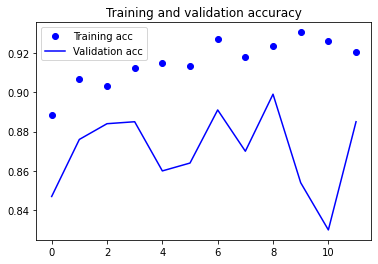

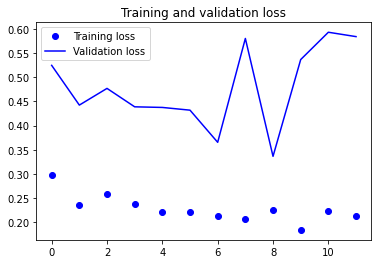

In [99]:
# 시각화를 통해 정확도 알아보기
acc = history_new.history['binary_accuracy']
val_acc = history_new.history['val_binary_accuracy']
loss = history_new.history['loss']
val_loss = history_new.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

음.. 확인을 해보니 마지막 12 Epoch에서 validation accuracy가 adam을 사용했을 때보단 높지만, loss와 그래프의 모양을 비교했을 때는 adam이 좀 더 loss의 점수가 낮고, 안정적인 그래프를 그리는 것을 볼 수 있었다. 따라서 optimizer를 **Adam**으로 사용했을 때가 더 결과가 좋았던 것 같다. 

Pre-trained Model로 이렇게 간단하게 모델을 학습시킬 수 있다는 것을 경험해보니 신기하고 흥미로웠다. 다만 아직 코드가 다 이해가 된 건 아니라서 아쉽다. 데이터 증강부터 다른 새로운 것들을 많이 배우는데 언제 코드를 다 이해할 수 있을까? ㅠㅠ 코딩은 어렵다..!